<a href="https://colab.research.google.com/github/anuragbantu/DL-Assignment-1/blob/main/Assignment-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.datasets import fashion_mnist

**Question 1**

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


In [3]:
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

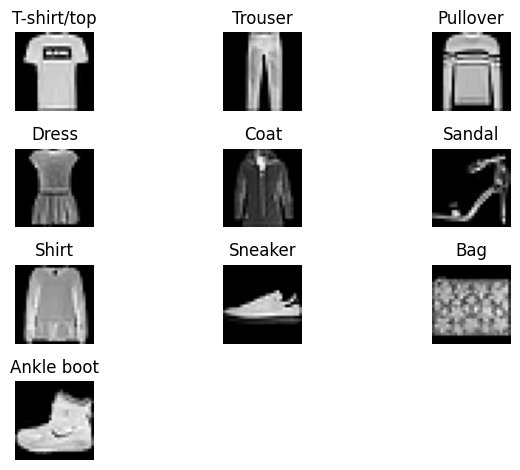

In [4]:
for i in range(10):
    idx = np.where(y_train == i)[0][0]
    plt.subplot(4, 3, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(class_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Question 2**

preparing the dataset.

In [5]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.0

In [6]:
def one_hot_encode(labels, num_classes=None):
    if num_classes is None:
        num_classes = np.max(labels) + 1

    encoded = np.zeros((len(labels), num_classes))

    encoded[np.arange(len(labels)), labels] = 1

    return encoded

y_train = one_hot_encode(y_train)


In [7]:
y_test = one_hot_encode(y_test)

Define a class for layers.

In [8]:
def sigmoid(x):
  return 0.5 * (1 + np.tanh(0.5 * x))

def sigmoid_d(x):
  s= sigmoid(x)
  return s*(1-s)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True) + 1e-8)
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def softmax_d(x):
    diag_s = np.diag(x)

    outer_s = np.outer(x, x)
    return diag_s - outer_s

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    return 1 - np.square(np.tanh(x))

def relu(x):
    return np.maximum(0, x)

def relu_d(x):
    return np.where(x > 0, 1, 0)

#CCE loss function
def categorical_cross_entropy(y_true, y_pred, layers, weight_decay=0):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred), axis=-1)
    loss = np.mean(loss)

    l2_penalty = weight_decay * sum(np.sum(layer.weights ** 2) for layer in layers)

    return loss + l2_penalty

#MSE loss
def squared_error_loss(y_true, y_pred):
    return (np.mean(np.sum((y_true - y_pred) ** 2, axis=1))/2)

activations = {"sigmoid":sigmoid,"softmax":softmax,"tanh":tanh,"relu":relu}

derivatives = {"sigmoid":sigmoid_d}





In [9]:
class layer:
  def __init__(self, input, neurons, activation, weight_init):
    if weight_init == "xavier":
        self.weights = np.random.randn(input, neurons) * np.sqrt(1 / input)
    else:
        self.weights = np.random.randn(input, neurons)
    self.bias = np.zeros((1, neurons))
    self.activation = activations[activation]
    self.activation_d = derivatives.get(activation, None)

  def forward(self, a_prev):
    self.a_prev = a_prev
    self.z = np.dot(self.a_prev,self.weights) + self.bias
    self.a = self.activation(self.z)
    return self.a

  def sgd(self,w_d,b_d,lr):
    self.weights -= lr*w_d
    self.bias -= lr*b_d

  def momentum_gd(self, w_d, b_d, lr, momentum=0.9):
    if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
    if not hasattr(self, 'm_b'):
        self.m_b = np.zeros_like(self.bias)
    self.m_w = momentum * self.m_w + lr * w_d
    self.m_b = momentum * self.m_b + lr * b_d
    self.weights -= self.m_w
    self.bias -= self.m_b

  def nesterov_gd(self, w_d, b_d, lr, momentum=0.9):
      if not hasattr(self, 'm_w'):
          self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      m_w_prev, m_b_prev = self.m_w, self.m_b
      self.m_w = momentum * self.m_w + lr * w_d
      self.m_b = momentum * self.m_b + lr * b_d
      self.weights -= momentum * m_w_prev + (1 + momentum) * self.m_w
      self.bias -= momentum * m_b_prev + (1 + momentum) * self.m_b

  def rmsprop(self, w_d, b_d, lr, decay_rate=0.9, epsilon=1e-8):
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      self.v_w = decay_rate * self.v_w + (1 - decay_rate) * np.square(w_d)
      self.v_b = decay_rate * self.v_b + (1 - decay_rate) * np.square(b_d)
      self.weights -= lr * w_d / (np.sqrt(self.v_w) + epsilon)
      self.bias -= lr * b_d / (np.sqrt(self.v_b) + epsilon)

  def adam(self, w_d, b_d, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):

      if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      if not hasattr(self, 't'):
          self.t = 0

      self.t += 1

      self.m_w = beta1 * self.m_w + (1 - beta1) * w_d
      self.m_b = beta1 * self.m_b + (1 - beta1) * b_d
      self.v_w = beta2 * self.v_w + (1 - beta2) * np.square(w_d)
      self.v_b = beta2 * self.v_b + (1 - beta2) * np.square(b_d)
      m_w_hat = self.m_w / (1 - beta1**self.t)
      m_b_hat = self.m_b / (1 - beta1**self.t)
      v_w_hat = self.v_w / (1 - beta2**self.t)
      v_b_hat = self.v_b / (1 - beta2**self.t)
      self.weights -= lr * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
      self.bias -= lr * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

  def nadam(self, w_d, b_d, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):
      if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      if not hasattr(self, 't'):
          self.t = 0
      self.t += 1
      self.m_w = beta1 * self.m_w + (1 - beta1) * w_d
      self.m_b = beta1 * self.m_b + (1 - beta1) * b_d
      self.v_w = beta2 * self.v_w + (1 - beta2) * np.square(w_d)
      self.v_b = beta2 * self.v_b + (1 - beta2) * np.square(b_d)
      m_w_hat = self.m_w / (1 - beta1**self.t)
      m_b_hat = self.m_b / (1 - beta1**self.t)
      v_w_hat = self.v_w / (1 - beta2**self.t)
      v_b_hat = self.v_b / (1 - beta2**self.t)
      m_w_bar = beta1 * m_w_hat + ((1 - beta1) / (1 - beta1**self.t)) * w_d
      m_b_bar = beta1 * m_b_hat + ((1 - beta1) / (1 - beta1**self.t)) * b_d
      self.weights -= lr * m_w_bar / (np.sqrt(v_w_hat) + epsilon)
      self.bias -= lr * m_b_bar / (np.sqrt(v_b_hat) + epsilon)

  def backprop(self, a_d, lr, optimizer, weight_decay=0):
    if self.activation_d:
      z_d = np.multiply(self.activation_d(self.z),a_d)
    else:
      z_d = a_d

    w_d = np.dot(self.a_prev.T,z_d) + weight_decay * self.weights
    b_d = np.sum(z_d,axis=0,keepdims=True)
    a_prev_d = np.dot(z_d,self.weights.T)

    if optimizer == 'sgd':
            self.sgd(w_d, b_d, lr)
    elif optimizer == 'momentum':
        self.momentum_gd(w_d, b_d, lr)
    elif optimizer == 'nesterov':
        self.nesterov_gd(w_d, b_d, lr)
    elif optimizer == 'rmsprop':
        self.rmsprop(w_d, b_d, lr)
    elif optimizer == 'adam':
        self.adam(w_d, b_d, lr)
    elif optimizer == 'nadam':
        self.nadam(w_d, b_d, lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer}")

    return a_prev_d



# Question 3

Implement backpropagation algorithm

# Question 4


In [10]:
!pip install wandb -Uq

In [11]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ma24m003 (ma24m003-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

In [13]:
import wandb
import numpy as np

sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [5, 10, 15]},
        'num_hidden_layers': {'values': [3, 4, 5]},
        'fc_layer_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005,0.005,0.05, 0.5]},
        'lr': {'values': [1e-3, 1e-4,1e-5]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="neural-network-hyperparam-tuning")

def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))





Create sweep with ID: 64ewixvw
Sweep URL: https://wandb.ai/ma24m003-iit-madras/neural-network-hyperparam-tuning/sweeps/64ewixvw


In [ ]:
#with categorical cross entropy loss

def train_network(config=None):
    with wandb.init(config=config, project="neural-network-hyperparam-tuning"):
        config = wandb.config
        run_name = (f"hl_{config['num_hidden_layers']}_bs_{config['batch_size']}_ac_{config['activation']}_"
            f"fc_{config['fc_layer_size']}_lr_{config['lr']}_opt_{config['optimizer']}_"
            f"wd_{config['weight_decay']}_wi_{config['weight_init']}_ep_{config['epochs']}")
        wandb.run.name = run_name

        layers = [
            layer(784, config.fc_layer_size, config.activation, config.weight_init)
        ]

        for _ in range(config.num_hidden_layers - 1):
            layers.append(layer(config.fc_layer_size, config.fc_layer_size, config.activation, config.weight_init))
        layers.append(layer(config.fc_layer_size, 10, "softmax", config.weight_init))

        num_samples = x_train.shape[0]

        for epoch in range(config.epochs):
            shuffled_indices = np.random.permutation(num_samples)
            x_train_shuffled = x_train[shuffled_indices]
            y_train_shuffled = y_train[shuffled_indices]

            epoch_loss = 0
            epoch_acc = 0

            for start in range(0, num_samples, config.batch_size):
                end = min(start + config.batch_size, num_samples)
                x_batch = x_train_shuffled[start:end]
                y_batch = y_train_shuffled[start:end]

                a = x_batch
                for l in layers:
                    a = l.forward(a)

                loss = categorical_cross_entropy(y_batch, a,layers, config.weight_decay)
                acc = accuracy(y_batch, a)

                epoch_loss += loss
                epoch_acc += acc

                a_d = a - y_batch
                for l in reversed(layers):
                    a_d = l.backprop(a_d, config.lr, config.optimizer, config.weight_decay)

            num_batches = max(1, num_samples // config.batch_size)
            avg_loss = epoch_loss / num_batches
            avg_acc = epoch_acc / num_batches

            a_val = x_val
            for l in layers:
                a_val = l.forward(a_val)

            val_loss = categorical_cross_entropy(y_val, a_val, layers, config.weight_decay)
            val_acc = accuracy(y_val, a_val)

            print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}, val_loss: {val_loss}, val_accuracy: {val_acc}")

            wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc,
                       "val_loss": val_loss, "val_accuracy": val_acc})

        a_test = x_test
        for l in layers:
            a_test = l.forward(a_test)

        test_loss = categorical_cross_entropy(y_test, a_test,layers, config.weight_decay)
        test_acc = accuracy(y_test, a_test)
        print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

        wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

        y_pred = np.argmax(a_test, axis=1)
        y_true = np.argmax(y_test, axis=1)
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")

        wandb.log({"confusion_matrix": wandb.Image(plt)})
        plt.close()



x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

wandb.agent(sweep_id, train_network, count=50)

wandb.finish()


wandb: Agent Starting Run: dx35zi9j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 762.0415597987841, Accuracy: 0.6745625741399762, val_loss: 693.3978305990375, val_accuracy: 0.7671666666666667
Epoch 2, Loss: 638.8564818201346, Accuracy: 0.7919261565836299, val_loss: 587.2034866117391, val_accuracy: 0.8023333333333333
Epoch 3, Loss: 544.2491159863004, Accuracy: 0.823571569790431, val_loss: 502.8512280417284, val_accuracy: 0.8243333333333334
Epoch 4, Loss: 467.6738453076429, Accuracy: 0.8395734480031632, val_loss: 433.6740822329241, val_accuracy: 0.8361666666666666
Epoch 5, Loss: 404.8989667642103, Accuracy: 0.8511516409648082, val_loss: 377.14296416708004, val_accuracy: 0.8428333333333333
Epoch 6, Loss: 353.7266134625527, Accuracy: 0.8607095195729537, val_loss: 331.03566137629724, val_accuracy: 0.8526666666666667
Epoch 7, Loss: 311.9486818636076, Accuracy: 0.8664739027283511, val_loss: 293.530578840597, val_accuracy: 0.848
Epoch 8, Loss: 278.0031233795108, Accuracy: 0.8735604487939898, val_loss: 262.925038156219, val_accuracy: 0.8601666666666666
Epoch 

accuracy,▁▅▆▆▆▇▇▇▇▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▅▅▄▃▃▂▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▅▆▆▆▇▇▇▇▇███
val_loss,█▇▆▅▄▃▃▂▂▂▂▁▁▁▁
accuracy,0.89982
epoch,15
loss,154.06811
test_accuracy,0.8295


wandb: Agent Starting Run: yds75cir with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 8.818501381139333, Accuracy: 0.47753703703703704, val_loss: 8.81262762127867, val_accuracy: 0.552
Epoch 2, Loss: 9.160120897080919, Accuracy: 0.5684074074074074, val_loss: 9.61033183056556, val_accuracy: 0.5713333333333334
Epoch 3, Loss: 10.227640219405517, Accuracy: 0.579037037037037, val_loss: 10.911874588929347, val_accuracy: 0.5765
Epoch 4, Loss: 11.706336912678733, Accuracy: 0.5833333333333334, val_loss: 12.547571297233247, val_accuracy: 0.582
Epoch 5, Loss: 13.461999594562153, Accuracy: 0.5854074074074074, val_loss: 14.409708847322523, val_accuracy: 0.578
Test Loss: 14.429292143324151, Test Accuracy: 0.5755


accuracy,▁▇███
epoch,▁▃▅▆█
loss,▁▂▃▅█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇█▇
val_loss,▁▂▄▆█
accuracy,0.58541
epoch,5
loss,13.462
test_accuracy,0.5755


wandb: Agent Starting Run: xtm9nds9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


<ipython-input-8-3fa72e0033b7>:9: RuntimeWarning: invalid value encountered in subtract
  e_x = np.exp(x - np.max(x, axis=-1, keepdims=True) + 1e-8)


Epoch 1, Loss: nan, Accuracy: 0.10045569057498518, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 2, Loss: nan, Accuracy: 0.10038159454653231, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 3, Loss: nan, Accuracy: 0.10036307053941909, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 4, Loss: nan, Accuracy: 0.10038159454653231, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 5, Loss: nan, Accuracy: 0.10041864256075875, val_loss: nan, val_accuracy: 0.09716666666666667
Test Loss: nan, Test Accuracy: 0.1


accuracy,█▂▁▂▅
epoch,▁▃▅▆█
test_accuracy,▁
val_accuracy,▁▁▁▁▁
accuracy,0.10042
epoch,5
loss,nan
test_accuracy,0.1
test_loss,nan
val_accuracy,0.09717
val_loss,nan


wandb: Agent Starting Run: gfut41a7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 2.3164385409810886, Accuracy: 0.11299644339063426, val_loss: 2.282537127693864, val_accuracy: 0.24083333333333334
Epoch 2, Loss: 2.245330157760173, Accuracy: 0.27832320687611145, val_loss: 2.181929343080606, val_accuracy: 0.25
Epoch 3, Loss: 2.0753471907564784, Accuracy: 0.24284973325429757, val_loss: 1.9629899595587177, val_accuracy: 0.2175
Epoch 4, Loss: 1.8794764924361413, Accuracy: 0.2447577059869591, val_loss: 1.8055429513758565, val_accuracy: 0.26366666666666666
Epoch 5, Loss: 1.7560057273273413, Accuracy: 0.3257631890930646, val_loss: 1.7033474026881097, val_accuracy: 0.32716666666666666
Test Loss: 1.694846475211743, Test Accuracy: 0.3411


accuracy,▁▆▅▅█
epoch,▁▃▅▆█
loss,█▇▅▃▁
test_accuracy,▁
test_loss,▁
val_accuracy,▂▃▁▄█
val_loss,█▇▄▂▁
accuracy,0.32576
epoch,5
loss,1.75601
test_accuracy,0.3411


wandb: Agent Starting Run: tlpjkbvr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 69.88401428714883, Accuracy: 0.5166851851851851, val_loss: 68.82910463496586, val_accuracy: 0.5913333333333334
Epoch 2, Loss: 70.7332652841958, Accuracy: 0.5852222222222222, val_loss: 73.70813775891968, val_accuracy: 0.5705
Epoch 3, Loss: 78.32661768328187, Accuracy: 0.5803888888888888, val_loss: 83.57592979733701, val_accuracy: 0.5778333333333333
Epoch 4, Loss: 89.94985868525228, Accuracy: 0.5892777777777778, val_loss: 96.79634140873482, val_accuracy: 0.591
Epoch 5, Loss: 104.48665467871176, Accuracy: 0.6037592592592592, val_loss: 112.44076586590826, val_accuracy: 0.6076666666666667
Epoch 6, Loss: 121.0556088151656, Accuracy: 0.616574074074074, val_loss: 129.83229392922973, val_accuracy: 0.6176666666666667
Epoch 7, Loss: 139.02742930801946, Accuracy: 0.6222962962962963, val_loss: 148.3753465380968, val_accuracy: 0.6196666666666667
Epoch 8, Loss: 158.04705196678555, Accuracy: 0.6289259259259259, val_loss: 167.9022576997547, val_accuracy: 0.624
Epoch 9, Loss: 177.87464130

accuracy,▁▅▅▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▁▁▂▃▄▅▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▄▁▂▃▆▇▇██▇
val_loss,▁▁▂▂▃▄▅▆▇█
accuracy,0.63239
epoch,10
loss,198.14731
test_accuracy,0.6218


wandb: Agent Starting Run: o4j5n3z4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 386.7030083005116, Accuracy: 0.767682384341637, val_loss: 439.8087938829775, val_accuracy: 0.7703333333333333
Epoch 2, Loss: 523.0435947017254, Accuracy: 0.7978079280347964, val_loss: 609.5141251006827, val_accuracy: 0.7788333333333334
Epoch 3, Loss: 743.864974883216, Accuracy: 0.7732428825622776, val_loss: 901.9749791424242, val_accuracy: 0.7651666666666667
Epoch 4, Loss: 1118.303684513275, Accuracy: 0.749678726769474, val_loss: 1346.434839118741, val_accuracy: 0.756
Epoch 5, Loss: 1625.3091247355608, Accuracy: 0.7543248319493872, val_loss: 1905.672136244563, val_accuracy: 0.7561666666666667
Epoch 6, Loss: 2291.467756897456, Accuracy: 0.7255894128113879, val_loss: 2768.2902252794393, val_accuracy: 0.7076666666666667
Epoch 7, Loss: 3116.263611279217, Accuracy: 0.7172672004744959, val_loss: 3319.549225374916, val_accuracy: 0.7076666666666667
Epoch 8, Loss: 3399.199555839085, Accuracy: 0.7232169335705813, val_loss: 3456.777670598067, val_accuracy: 0.7133333333333334
Epoch 

accuracy,▆█▆▄▄▂▁▂▂▁▂▂▁▁▂
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,▁▁▁▂▃▃▄▅▅▅▅▅▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▇█▇▆▆▂▂▃▂▃▄▁▂▁▂
val_loss,▁▁▂▂▃▄▄▄▅▅▅▅▆▇█
accuracy,0.71883
epoch,15
loss,6123.2335
test_accuracy,0.7086


wandb: Agent Starting Run: 5lirc8ds with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Loss: 82877.95903177676, Accuracy: 0.5591842027267339, val_loss: 81987.32963120166, val_accuracy: 0.6463333333333333
Epoch 2, Loss: 81077.83054101908, Accuracy: 0.668531416716064, val_loss: 80094.03129231559, val_accuracy: 0.6803333333333333
Epoch 3, Loss: 79302.2096314295, Accuracy: 0.7250296384113811, val_loss: 78424.19917893448, val_accuracy: 0.7411666666666666
Epoch 4, Loss: 77620.14125493009, Accuracy: 0.7625222288085358, val_loss: 76660.36020271022, val_accuracy: 0.7656666666666667
Epoch 5, Loss: 75676.56242271938, Accuracy: 0.7636521932424422, val_loss: 74566.75121333491, val_accuracy: 0.7738333333333334
Epoch 6, Loss: 73537.09564379843, Accuracy: 0.771765708358032, val_loss: 72430.93530634398, val_accuracy: 0.779
Epoch 7, Loss: 71300.58947423659, Accuracy: 0.7754149377593361, val_loss: 69944.97145206368, val_accuracy: 0.7771666666666667
Epoch 8, Loss: 68375.5439595055, Accuracy: 0.7691723473621814, val_loss: 66620.19323653336, val_accuracy: 0.7625
Epoch 9, Loss: 64874.

accuracy,▁▅▆█████▇▇▇██▇▆
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,███▇▇▇▇▆▆▅▅▄▃▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▆▇███▇▆▆▇▇▇▄▄
val_loss,███▇▇▇▇▆▆▅▄▃▂▂▁
accuracy,0.70967
epoch,15
loss,25811.4793
test_accuracy,0.692


wandb: Agent Starting Run: n8e8mwsg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 6.307913897197011, Accuracy: 0.48523996638987743, val_loss: 6.999107091189679, val_accuracy: 0.7023333333333334
Epoch 2, Loss: 7.833469917290566, Accuracy: 0.7761281633056544, val_loss: 8.33036894979217, val_accuracy: 0.8031666666666667
Epoch 3, Loss: 8.603063719304686, Accuracy: 0.8202723408461843, val_loss: 8.851753834441038, val_accuracy: 0.832
Epoch 4, Loss: 8.981560391785198, Accuracy: 0.8456343910636615, val_loss: 9.092947029523385, val_accuracy: 0.8471666666666666
Epoch 5, Loss: 9.164755271144923, Accuracy: 0.8571693357058126, val_loss: 9.209697834118504, val_accuracy: 0.8593333333333333
Epoch 6, Loss: 9.26614778729658, Accuracy: 0.8671596975088968, val_loss: 9.262445487673771, val_accuracy: 0.8668333333333333
Epoch 7, Loss: 9.2899126762087, Accuracy: 0.8740547153024911, val_loss: 9.33987171112403, val_accuracy: 0.8641666666666666
Epoch 8, Loss: 9.387953016479571, Accuracy: 0.8780582740213523, val_loss: 9.413836782788428, val_accuracy: 0.8708333333333333
Epoch 9, 

accuracy,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▄▆▇▇▇▇███
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇█▇███
val_loss,▁▅▆▇▇▇▇███
accuracy,0.88801
epoch,10
loss,9.5349
test_accuracy,0.8196


wandb: Agent Starting Run: vgu2270g with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 59.15127485936909, Accuracy: 0.4672980921312772, val_loss: 60.090787705954675, val_accuracy: 0.6118333333333333
Epoch 2, Loss: 63.40371960420749, Accuracy: 0.6326611308817714, val_loss: 65.2016483947513, val_accuracy: 0.6376666666666667
Epoch 3, Loss: 66.17230658067356, Accuracy: 0.6496762554369316, val_loss: 66.10539578447505, val_accuracy: 0.6266666666666667
Epoch 4, Loss: 66.71476645955825, Accuracy: 0.6570161130881772, val_loss: 66.45805484019226, val_accuracy: 0.6515
Epoch 5, Loss: 67.06078592618648, Accuracy: 0.6583938809806247, val_loss: 66.18014181819423, val_accuracy: 0.66
Epoch 6, Loss: 66.99803558599031, Accuracy: 0.6593329873467775, val_loss: 67.0079833171136, val_accuracy: 0.654
Epoch 7, Loss: 66.99536744769257, Accuracy: 0.6581282127323053, val_loss: 66.81442207252844, val_accuracy: 0.6435
Epoch 8, Loss: 67.07762050445783, Accuracy: 0.6604389086595492, val_loss: 66.37514968297552, val_accuracy: 0.6526666666666666
Epoch 9, Loss: 66.99991755190095, Accuracy: 

accuracy,▁▇█████████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,▁▅▇████████████
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▂▅▅▅▄▅█▅▄▃▇▆▃
val_loss,▁▆▆▇▆▇▇▇▇█▇▇█▇█
accuracy,0.66149
epoch,15
loss,67.08058
test_accuracy,0.5154


wandb: Agent Starting Run: qea7w6zp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 344.47271656110274, Accuracy: 0.45526270264926844, val_loss: 349.19961616409734, val_accuracy: 0.5498333333333333
Epoch 2, Loss: 357.92642957337404, Accuracy: 0.5841612297350732, val_loss: 366.1221176406675, val_accuracy: 0.6056666666666667
Epoch 3, Loss: 376.0520959064328, Accuracy: 0.6269399960458679, val_loss: 385.4731521222804, val_accuracy: 0.6386666666666667
Epoch 4, Loss: 395.5994571132777, Accuracy: 0.6493117338869118, val_loss: 404.6119412204043, val_accuracy: 0.6531666666666667
Epoch 5, Loss: 416.5708590640901, Accuracy: 0.6594133056544088, val_loss: 429.3522901114544, val_accuracy: 0.6516666666666666
Epoch 6, Loss: 444.91490417175794, Accuracy: 0.6740991992882562, val_loss: 459.3995102323418, val_accuracy: 0.693
Epoch 7, Loss: 475.2039606273, Accuracy: 0.6996651344404904, val_loss: 489.4178335264867, val_accuracy: 0.7123333333333334
Epoch 8, Loss: 505.10573595033014, Accuracy: 0.7132142151047846, val_loss: 520.204158619521, val_accuracy: 0.7081666666666667
Epo

accuracy,▁▄▅▆▆▆▇▇▇███▇▇▇
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,▁▁▁▂▂▂▃▃▄▄▅▅▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▅▆▇▇▇▇█▇▇▇▇
val_loss,▁▁▁▂▂▂▃▃▄▄▅▅▆▇█
accuracy,0.71847
epoch,15
loss,850.9626
test_accuracy,0.7125


wandb: Agent Starting Run: kz3b2ywn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 496.46582454915404, Accuracy: 0.761095880260818, val_loss: 776.7637772151904, val_accuracy: 0.7516666666666667
Epoch 2, Loss: 1138.8337327251897, Accuracy: 0.7510743924125667, val_loss: 1418.9934489123582, val_accuracy: 0.7436666666666667
Epoch 3, Loss: 1617.5016669747586, Accuracy: 0.716378927089508, val_loss: 1826.100016850876, val_accuracy: 0.7165
Epoch 4, Loss: 2105.1585684665856, Accuracy: 0.7075800237107291, val_loss: 2424.4977724689875, val_accuracy: 0.6973333333333334
Epoch 5, Loss: 2494.6067822907107, Accuracy: 0.7069687314759929, val_loss: 2431.4923751004535, val_accuracy: 0.701
Epoch 6, Loss: 2478.1689378224087, Accuracy: 0.6919828097213989, val_loss: 2537.6098441364634, val_accuracy: 0.6886666666666666
Epoch 7, Loss: 2865.672538000242, Accuracy: 0.6928534380557202, val_loss: 3187.8597369833074, val_accuracy: 0.6568333333333334
Epoch 8, Loss: 3453.8569288565554, Accuracy: 0.7008558091286307, val_loss: 3657.821445610015, val_accuracy: 0.6993333333333334
Epoch 9

accuracy,█▇▃▃▃▁▁▂▃▂▃▃▂▅▄
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,▁▁▁▂▂▂▂▂▂▃▄▅▇██
test_accuracy,▁
test_loss,▁
val_accuracy,█▇▅▄▄▃▁▄▅▄▆▃▄▇▄
val_loss,▁▁▁▂▂▂▂▂▃▄▅▆███
accuracy,0.7251
epoch,15
loss,20106.36269
test_accuracy,0.6936


wandb: Agent Starting Run: njgsw2c8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 5.3559712424409325, Accuracy: 0.17928899762752076, val_loss: 5.349568713989113, val_accuracy: 0.19916666666666666
Epoch 2, Loss: 5.340912897485759, Accuracy: 0.33571816923685255, val_loss: 5.479350557465181, val_accuracy: 0.4081666666666667
Epoch 3, Loss: 5.623420244254171, Accuracy: 0.4300551107156979, val_loss: 5.726036167456266, val_accuracy: 0.4645
Epoch 4, Loss: 5.809158909914093, Accuracy: 0.5173611111111112, val_loss: 5.8838523491564265, val_accuracy: 0.556
Epoch 5, Loss: 6.00889141775892, Accuracy: 0.5806395808620008, val_loss: 6.137007348672163, val_accuracy: 0.599
Epoch 6, Loss: 6.280997793498981, Accuracy: 0.6471246045867931, val_loss: 6.411475336445941, val_accuracy: 0.6663333333333333
Epoch 7, Loss: 6.537393018189843, Accuracy: 0.6980340549624358, val_loss: 6.643825176995628, val_accuracy: 0.7065
Epoch 8, Loss: 6.752379998261909, Accuracy: 0.7367969058916567, val_loss: 6.845857818994496, val_accuracy: 0.753
Epoch 9, Loss: 6.9415547800629644, Accuracy: 0.7596

accuracy,▁▃▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▁▂▃▄▅▆▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▅▆▇▇███
val_loss,▁▂▂▃▄▅▆▇▇█
accuracy,0.77009
epoch,10
loss,7.09642
test_accuracy,0.6656


wandb: Agent Starting Run: o8nor97g with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.0673806657495897, Accuracy: 0.5686165480427047, val_loss: 0.6266761585767571, val_accuracy: 0.7706666666666667
Epoch 2, Loss: 0.5629487662121515, Accuracy: 0.7948485073151442, val_loss: 0.5303799205295721, val_accuracy: 0.8068333333333333
Epoch 3, Loss: 0.48033597378940207, Accuracy: 0.8198831059707394, val_loss: 0.48661216282720443, val_accuracy: 0.8185
Epoch 4, Loss: 0.4340641878823679, Accuracy: 0.844028024911032, val_loss: 0.42483268362970006, val_accuracy: 0.8531666666666666
Epoch 5, Loss: 0.39213717169528617, Accuracy: 0.863211743772242, val_loss: 0.3902120347178233, val_accuracy: 0.8581666666666666
Epoch 6, Loss: 0.36261020623282775, Accuracy: 0.872806692368525, val_loss: 0.38817671229938494, val_accuracy: 0.8618333333333333
Epoch 7, Loss: 0.34375319560766127, Accuracy: 0.8796893534994069, val_loss: 0.38510898988778164, val_accuracy: 0.857
Epoch 8, Loss: 0.32997329827391614, Accuracy: 0.8827785191775405, val_loss: 0.34763217147450026, val_accuracy: 0.87383333333

accuracy,▁▆▆▇▇▇▇████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▆▆▆▆▇▇▇▇███▇
val_loss,█▆▅▃▃▃▂▂▂▃▁▁▁▁▁
accuracy,0.90682
epoch,15
loss,0.25985
test_accuracy,0.8359


wandb: Agent Starting Run: ugwfr5ki with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.9811404560333177, Accuracy: 0.6206133847370503, val_loss: 0.6211474070072892, val_accuracy: 0.7765
Epoch 2, Loss: 0.5144074484153885, Accuracy: 0.8093058026888098, val_loss: 0.4608064755250225, val_accuracy: 0.8275
Epoch 3, Loss: 0.42520000956100973, Accuracy: 0.8476176354290232, val_loss: 0.4043064736710659, val_accuracy: 0.8575
Epoch 4, Loss: 0.37512288536287247, Accuracy: 0.8666468960063266, val_loss: 0.36642893421392136, val_accuracy: 0.8718333333333333
Epoch 5, Loss: 0.3450817292489021, Accuracy: 0.8774651542111507, val_loss: 0.3471470164946689, val_accuracy: 0.878
Epoch 6, Loss: 0.32361658499964663, Accuracy: 0.8842860320284698, val_loss: 0.34334460630252944, val_accuracy: 0.877
Epoch 7, Loss: 0.30872380822364115, Accuracy: 0.8892286971134835, val_loss: 0.34066805102150716, val_accuracy: 0.8778333333333334
Epoch 8, Loss: 0.29610165102193664, Accuracy: 0.8934299624357454, val_loss: 0.33089229279016913, val_accuracy: 0.8796666666666667
Epoch 9, Loss: 0.285272164561

accuracy,▁▅▆▇▇▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇▇▇▇██▇████
val_loss,█▄▃▂▂▂▂▁▁▁▂▁▁▁▁
accuracy,0.91534
epoch,15
loss,0.23546
test_accuracy,0.845


wandb: Agent Starting Run: 9wurglwz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 6.1806148491785455, Accuracy: 0.48863804863582444, val_loss: 7.273771587978569, val_accuracy: 0.7538333333333334
Epoch 2, Loss: 7.900613061189639, Accuracy: 0.7917408066429419, val_loss: 8.31883616652244, val_accuracy: 0.8151666666666667
Epoch 3, Loss: 8.533893560906638, Accuracy: 0.8245971727955713, val_loss: 8.68115613887963, val_accuracy: 0.8415
Epoch 4, Loss: 8.838700655135709, Accuracy: 0.8493722815342033, val_loss: 8.932099061964472, val_accuracy: 0.856
Epoch 5, Loss: 9.00296188837944, Accuracy: 0.8610060794780545, val_loss: 9.05026936289155, val_accuracy: 0.8626666666666667
Epoch 6, Loss: 9.059382786194362, Accuracy: 0.8712435745353895, val_loss: 9.121285373388508, val_accuracy: 0.8595
Epoch 7, Loss: 9.137480442212766, Accuracy: 0.8760256030051404, val_loss: 9.199534440650641, val_accuracy: 0.8608333333333333


In [ ]:
#best model for cross entropy


wandb.init(project="neural-network-hyperparam-tuning", name="best_model_evaluation")

best_config = {
    "activation": "relu",
    "batch_size": 64,
    "epochs": 10,
    "fc_layer_size": 128,
    "lr": 0.001,
    "num_hidden_layers": 3,
    "optimizer": "nadam",
    "weight_decay": 0.0005,
    "weight_init": "xavier"
}

layers = [
    layer(784, best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"])
]
for _ in range(best_config["num_hidden_layers"] - 1):
    layers.append(layer(best_config["fc_layer_size"], best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"]))
layers.append(layer(best_config["fc_layer_size"], 10, "softmax", best_config["weight_init"]))

num_samples = x_train.shape[0]

for epoch in range(best_config["epochs"]):
    shuffled_indices = np.random.permutation(num_samples)
    x_train_shuffled = x_train[shuffled_indices]
    y_train_shuffled = y_train[shuffled_indices]

    epoch_loss = 0
    epoch_acc = 0

    for start in range(0, num_samples, best_config["batch_size"]):
        end = min(start + best_config["batch_size"], num_samples)
        x_batch = x_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        a = x_batch
        for l in layers:
            a = l.forward(a)

        loss = categorical_cross_entropy(y_batch, a, layers, best_config["weight_decay"])
        acc = accuracy(y_batch, a)

        epoch_loss += loss
        epoch_acc += acc

        a_d = a - y_batch
        for l in reversed(layers):
            a_d = l.backprop(a_d, best_config["lr"], best_config["optimizer"])

    num_batches = max(1, num_samples // best_config["batch_size"])
    avg_loss = epoch_loss / num_batches
    avg_acc = epoch_acc / num_batches

    print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}")

    wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc})


a_test = x_test
for l in layers:
    a_test = l.forward(a_test)

test_loss = categorical_cross_entropy(y_test, a_test, layers, best_config["weight_decay"])
test_acc = accuracy(y_test, a_test)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

y_pred = np.argmax(a_test, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of Best Model")

wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

wandb.finish()

# Question 8

In [ ]:
#with MSE loss

def train_network(config=None):
    with wandb.init(config=config, project="neural-network-hyperparam-tuning"):
        config = wandb.config
        run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
        wandb.run.name = run_name

        layers = [
            layer(784, config.fc_layer_size, config.activation, config.weight_init)
        ]

        for _ in range(config.num_hidden_layers - 1):
            layers.append(layer(config.fc_layer_size, config.fc_layer_size, config.activation, config.weight_init))
        layers.append(layer(config.fc_layer_size, 10, "softmax", config.weight_init))

        num_samples = x_train.shape[0]

        for epoch in range(config.epochs):
            shuffled_indices = np.random.permutation(num_samples)
            x_train_shuffled = x_train[shuffled_indices]
            y_train_shuffled = y_train[shuffled_indices]

            epoch_loss = 0
            epoch_acc = 0

            for start in range(0, num_samples, config.batch_size):
                end = min(start + config.batch_size, num_samples)
                x_batch = x_train_shuffled[start:end]
                y_batch = y_train_shuffled[start:end]

                a = x_batch
                for l in layers:
                    a = l.forward(a)

                loss = squared_error_loss(y_batch, a)
                acc = accuracy(y_batch, a)

                epoch_loss += loss
                epoch_acc += acc

                a_d = a - y_batch
                for l in reversed(layers):
                    a_d = l.backprop(a_d, config.lr, config.optimizer)

            num_batches = max(1, num_samples // config.batch_size)
            avg_loss = epoch_loss / num_batches
            avg_acc = epoch_acc / num_batches

            a_val = x_val
            for l in layers:
                a_val = l.forward(a_val)

            val_loss = squared_error_loss(y_val, a_val)
            val_acc = accuracy(y_val, a_val)

            print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}, val_loss: {val_loss}, val_accuracy: {val_acc}")

            wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc,
                       "val_loss": val_loss, "val_accuracy": val_acc})

        a_test = x_test
        for l in layers:
            a_test = l.forward(a_test)

        test_loss = squared_error_loss(y_test, a_test)
        test_acc = accuracy(y_test, a_test)
        print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

        wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

        y_pred = np.argmax(a_test, axis=1)
        y_true = np.argmax(y_test, axis=1)
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")

        wandb.log({"confusion_matrix": wandb.Image(plt)})
        plt.close()



x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

wandb.agent(sweep_id, train_network, count=5)

wandb.finish()


In [ ]:
#best model for MSE

wandb.init(project="neural-network-hyperparam-tuning", name="best_model_evaluation")

best_config = {
    "activation": "sigmoid",
    "batch_size": 64,
    "epochs": 10,
    "fc_layer_size": 128,
    "lr": 0.001,
    "num_hidden_layers": 4,
    "optimizer": "momentum",
    "weight_decay": 0.5,
    "weight_init": "xavier"
}

layers = [
    layer(784, best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"])
]
for _ in range(best_config["num_hidden_layers"] - 1):
    layers.append(layer(best_config["fc_layer_size"], best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"]))
layers.append(layer(best_config["fc_layer_size"], 10, "softmax", best_config["weight_init"]))

num_samples = x_train.shape[0]

for epoch in range(best_config["epochs"]):
    shuffled_indices = np.random.permutation(num_samples)
    x_train_shuffled = x_train[shuffled_indices]
    y_train_shuffled = y_train[shuffled_indices]

    epoch_loss = 0
    epoch_acc = 0

    for start in range(0, num_samples, best_config["batch_size"]):
        end = min(start + best_config["batch_size"], num_samples)
        x_batch = x_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        a = x_batch
        for l in layers:
            a = l.forward(a)

        loss = squared_error_loss(y_batch, a)
        acc = accuracy(y_batch, a)

        epoch_loss += loss
        epoch_acc += acc

        a_d = a - y_batch
        for l in reversed(layers):
            a_d = l.backprop(a_d, best_config["lr"], best_config["optimizer"])

    num_batches = max(1, num_samples // best_config["batch_size"])
    avg_loss = epoch_loss / num_batches
    avg_acc = epoch_acc / num_batches

    print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}")

    wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc})


a_test = x_test
for l in layers:
    a_test = l.forward(a_test)

test_loss = squared_error_loss(y_test, a_test)
test_acc = accuracy(y_test, a_test)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

y_pred = np.argmax(a_test, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of Best Model")

wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

wandb.finish()

# Question 10

In [ ]:
from tensorflow.keras.datasets import mnist


In [ ]:
(x_1_train, y_1_train), (x_1_test, y_1_test) = mnist.load_data()

x_1_train = x_1_train.reshape(x_1_train.shape[0], 28, 28, 1)
x_1_train = x_1_train.astype('float32') / 255.0

In [ ]:
y_1_train = one_hot_encode(y_1_train)
y_1_test = one_hot_encode(y_1_test)